In [ ]:
import astra
import numpy as np
from scipy.sparse.linalg import lsqr

# Parameters
N = 32
M = int(2 ** np.ceil(np.log2(N * np.sqrt(2))))
angles = np.linspace(0, np.pi, 5, False)

# Create geometries
vol_geom = astra.create_vol_geom(N, N)
proj_geom = astra.create_proj_geom('parallel', 1.0, M, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Create phantom
phantom = np.zeros((N, N))
center = N // 2
k = 1
phantom[center - 1:center + k, center - k:center + k] = 1
phantom_id = astra.data2d.create('-vol', vol_geom, phantom)

# Generate sinogram using ASTRA
sinogram_id, sinogram = astra.create_sino(phantom_id, proj_id)

# ART reconstruction (via ASTRA)
rec_id = astra.data2d.create('-vol', vol_geom)
cfg = astra.astra_dict('SART')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 20)
rec_art = astra.data2d.get(rec_id)

# Custom FBP-like reconstruction using system matrix
matrix_id = astra.projector.matrix(proj_id)
W = astra.matrix.get(matrix_id)  # sparse matrix
rec_fbp = lsqr(W, sinogram.ravel())[0].reshape(N, N)

# Clean up ASTRA memory
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.data2d.delete(phantom_id)
astra.projector.delete(proj_id)
astra.matrix.delete(matrix_id)

# Return relevant data for further use
result = {
    "phantom": phantom,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
}


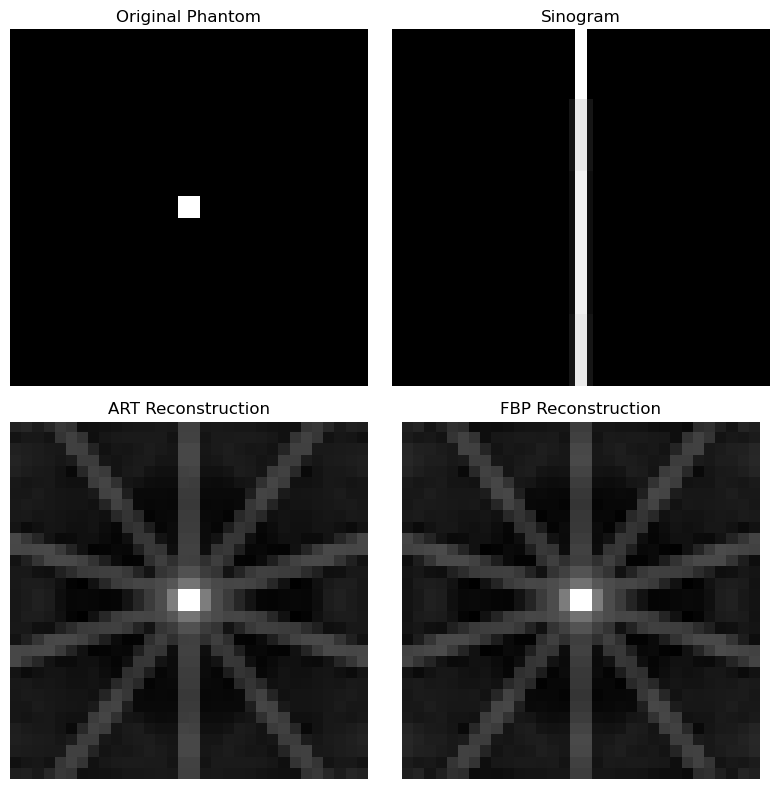

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstruction_grid(phantom, sinogram, rec_art, rec_fbp):
    """
    Plot a 2x2 comparison grid:
    (0,0): Original phantom
    (0,1): Sinogram
    (1,0): ART reconstruction
    (1,1): FBP reconstruction
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    plt.gray()

    axes[0, 0].imshow(phantom)
    axes[0, 0].set_title('Original Phantom')

    axes[0, 1].imshow(sinogram, aspect='auto')
    axes[0, 1].set_title('Sinogram')

    axes[1, 0].imshow(rec_art)
    axes[1, 0].set_title('ART Reconstruction')

    axes[1, 1].imshow(rec_fbp)
    axes[1, 1].set_title('FBP Reconstruction')

    for ax in axes.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_reconstruction_grid(
    result["phantom"],
    result["sinogram"],
    result["rec_art"],
    result["rec_fbp"]
)


Initial error: 197.307483
[4] Improved error: 196.952118
[7] Improved error: 196.490582
[8] Improved error: 196.039029
[9] Improved error: 195.751840
[11] Improved error: 195.422386
[13] Improved error: 195.058797
[14] Improved error: 194.621788
[16] Improved error: 194.214221
[19] Improved error: 193.835367
[20] Improved error: 193.435502
[21] Improved error: 193.007633
[23] Improved error: 192.711561
[26] Improved error: 192.268229
[30] Improved error: 191.851489
[31] Improved error: 191.407341
[32] Improved error: 191.126925
[34] Improved error: 190.766576
[35] Improved error: 190.455872
[40] Improved error: 190.061052
[43] Improved error: 189.647321
[45] Improved error: 189.313289
[46] Improved error: 188.862242
[47] Improved error: 188.417497
[49] Improved error: 188.052461
[50] Improved error: 187.578810
[51] Improved error: 187.166194
[52] Improved error: 186.720434
[53] Improved error: 186.264130
[54] Improved error: 185.878363
[55] Improved error: 185.459674
[57] Improved erro

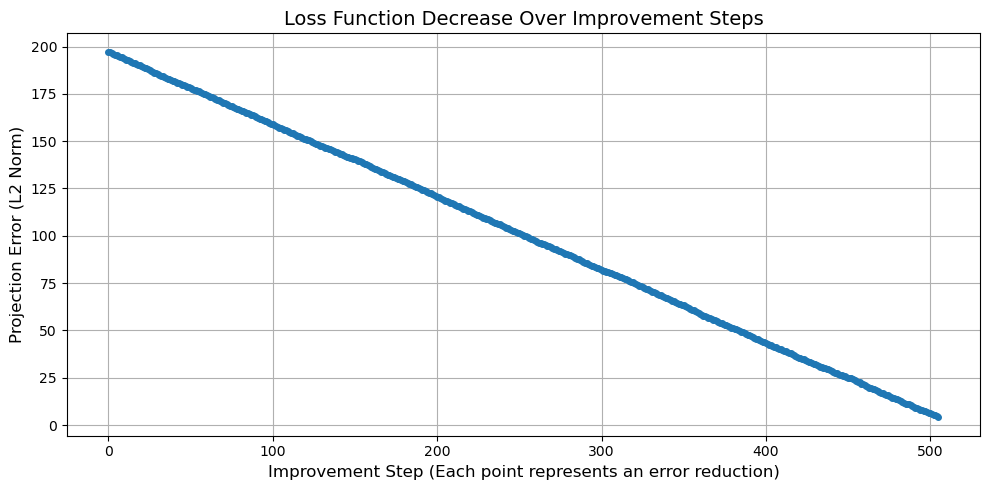

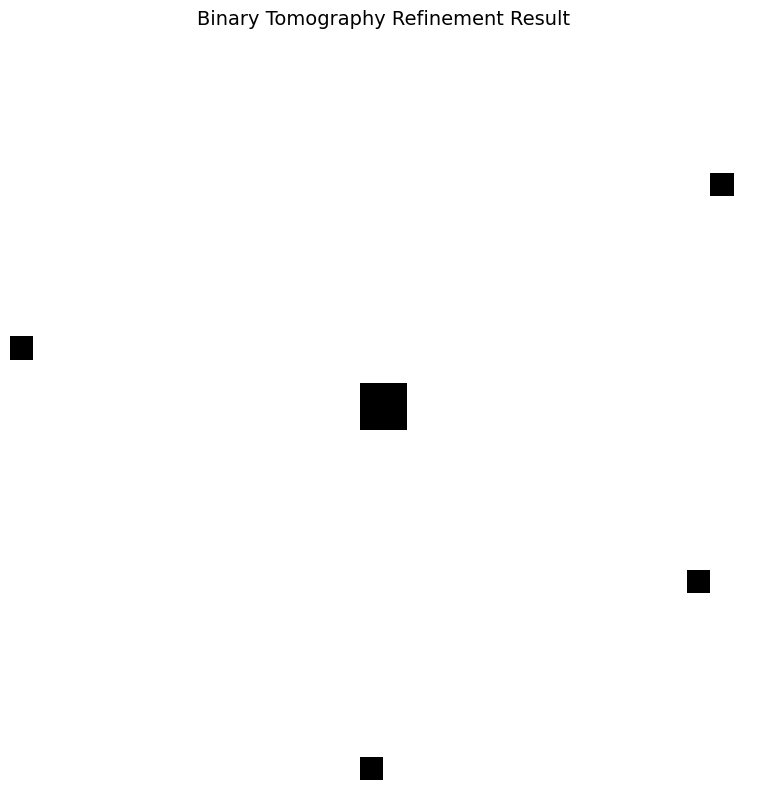

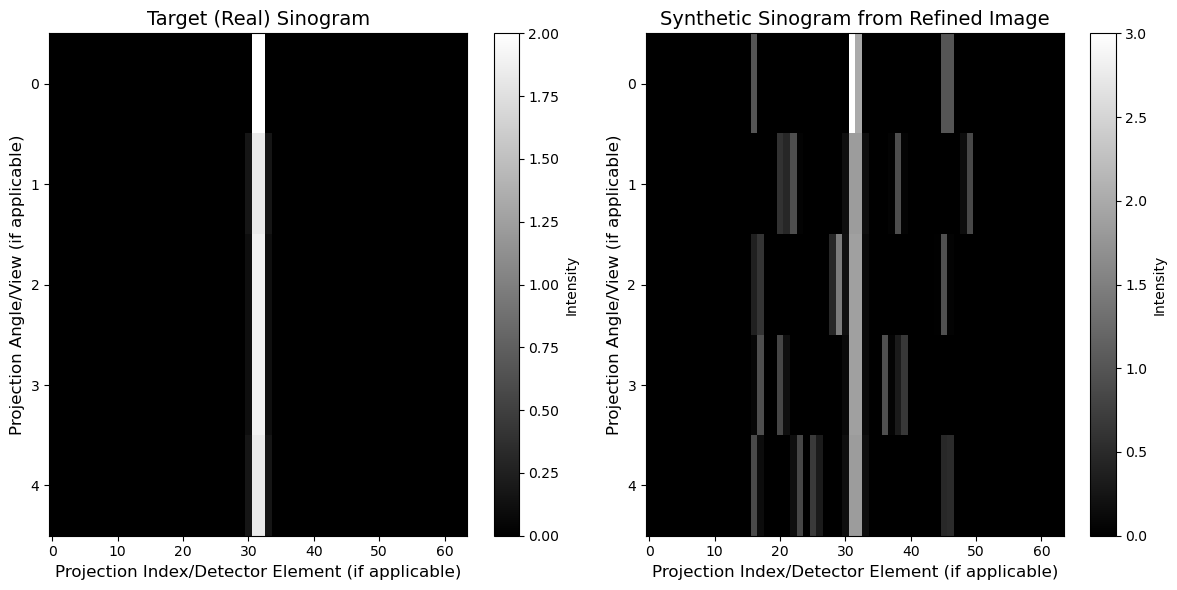

In [16]:
threshold = 0.5
max_iter = 5000
epsilon = 0.5
verbose = True

X_init = np.random.randint(0, 2, size=(N, N), dtype=np.bool_)  # Random binary image
W = result["system_matrix"]
sinogram = result["sinogram"]
N = X_init.shape[0]
X = (X_init > threshold).astype(np.uint8).ravel()
sino_target = sinogram.ravel()

def proj_error(x_bin):
    return np.linalg.norm(W @ x_bin - sino_target)

best_X = X.copy()
best_err = proj_error(X)
loss_history = [best_err] # To store loss values for plotting

print(f"Initial error: {best_err:.6f}")

# --- Binary Tomography Refinement Loop (Greedy Local Search) ---
for iteration in range(max_iter):
    idx = np.random.randint(0, N * N) # Choose a random pixel index
    X[idx] = 1 - X[idx]  # Flip the pixel (0 to 1, or 1 to 0)

    # Calculate error for the flipped image. This replaces proj_error(X)
    current_proj_error = np.linalg.norm(W @ X - sino_target)

    if current_proj_error < best_err:
        best_err = current_proj_error
        best_X = X.copy() # Store the image that yielded the better error
        loss_history.append(best_err) # Store improved loss
        if verbose:
            print(f"[{iteration}] Improved error: {best_err:.6f}")
        if best_err < epsilon:
            if verbose:
                print(f"Reached desired error < {epsilon} at iteration {iteration}")
            break # Stop if error is below epsilon
    else:
        X[idx] = 1 - X[idx]  # Revert the flip if it didn't improve the error

# Reshape the best binary image back to its original N x N dimensions
refined = best_X.reshape(N, N)

# --- Visualization of Loss Function Decrease ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o', linestyle='-', markersize=4)
plt.title('Loss Function Decrease Over Improvement Steps', fontsize=14)
plt.xlabel('Improvement Step (Each point represents an error reduction)', fontsize=12)
plt.ylabel('Projection Error (L2 Norm)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot the refined binary image ---
plt.figure(figsize=(8, 8))
plt.imshow(refined, cmap='binary', interpolation='none')
plt.title('Binary Tomography Refinement Result', fontsize=14)
plt.axis('off') # Hide axes for cleaner image display
plt.tight_layout()
plt.show()

# --- Synthetic Sinogram vs. Real Sinogram Visualization ---
# Calculate the synthetic sinogram from the final refined binary image
synthetic_sinogram = (W @ refined.ravel()).reshape(sinogram.shape) # Reshape back to original sinogram dimensions for plotting

plt.figure(figsize=(12, 6))

# Plot the Target (Real) Sinogram
plt.subplot(1, 2, 1)
plt.imshow(sino_target.reshape(sinogram.shape), cmap='gray', aspect='auto') # Reshape sino_target for imshow
plt.title('Target (Real) Sinogram', fontsize=14)
plt.xlabel('Projection Index/Detector Element (if applicable)', fontsize=12)
plt.ylabel('Projection Angle/View (if applicable)', fontsize=12)
plt.colorbar(label='Intensity')

# Plot the Synthetic Sinogram from the Refined Image
plt.subplot(1, 2, 2)
plt.imshow(synthetic_sinogram, cmap='gray', aspect='auto')
plt.title('Synthetic Sinogram from Refined Image', fontsize=14)
plt.xlabel('Projection Index/Detector Element (if applicable)', fontsize=12)
plt.ylabel('Projection Angle/View (if applicable)', fontsize=12)
plt.colorbar(label='Intensity')

plt.tight_layout()
plt.show()